Project repository: https://osf.io/jpzr8/?view_only=e7f22d0fcd0e44d9a8e93fd242d0851d

This notebook contains analysis that was used in the paper titled, 
### "Water mass characteristics of the Antarctic margins and the production and seasonality of Dense Shelf Water"

This is the first of the analysis notebooks

Make sure to run the Python notebooks in the following order:
1. MEOP_Preprocessing_data_SO.ipynb - if you want to generate the dfmg.csv from scratch yourself. Else, use the file provided.
2. MEOP_Analysis_Part1_OSFcopy.ipynb
3. WaterMassThickness_OSFcopy.ipynb
4. Wind_Stress_Analysis_OSFcopy.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
from matplotlib.colorbar import Colorbar 

In [2]:
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 

<IPython.core.display.Javascript object>


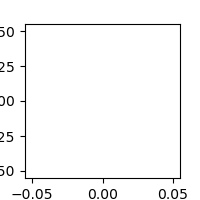

In [3]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

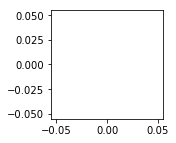

In [4]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

#### Read the merged dataframe "dfmg.csv" which was built using MEOP_Preprocessing_data_SO.ipynb

The pre-built "dfmg.csv" is also available for download from: https://drive.google.com/open?id=1GeUjUwLfuU840JQmxzCFKo8rrxv7eom6

In [3]:
dfmg = pd.read_csv("dfmg_corrected_DIST_IS_GL.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [4]:
dfmg["DIST_min"] = dfmg.loc[:, ["DIST_GLINE", "DIST_ISE"]].min(axis=1)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [5]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman', 'SHELF_BREAK_PROFILE',
       'DIST_ISE', 'DIST_min'],
      dtype='object')

In [6]:
sel_sal35 = (dfmg.PSAL_ADJUSTED > 35) #& (dfmg.LONGITUDE > 150)

In [7]:
dfmg.loc[sel_sal35, "PLATFORM_NUMBER"].unique()

array(["b'00057726'", "b'00021078'", "b'00009654'", "b'00012426'",
       "b'00022014'", "b'00022062'", "b'00022056'", "b'00027498'"],
      dtype=object)

In [8]:
sel_tags = dfmg.PLATFORM_NUMBER.isin(dfmg.loc[sel_sal35, "PLATFORM_NUMBER"].unique())

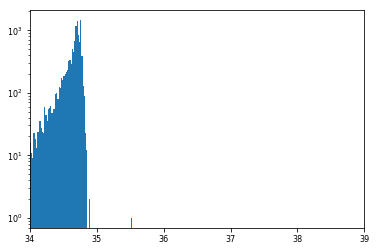

In [147]:
sel_tags1 = dfmg.PLATFORM_NUMBER.isin([dfmg.loc[sel_sal35, "PLATFORM_NUMBER"].unique()[7]])
plt.hist(dfmg.loc[sel_tags1, "PSAL_ADJUSTED"].dropna().values, bins=100)
plt.xlim(34, 39)
plt.yscale("log")

In [148]:
len(dfmg.PLATFORM_NUMBER.unique())

589

In [9]:
import cartopy.crs as ccrs
import cartopy
import fiona
import shapely.geometry as sgeom
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


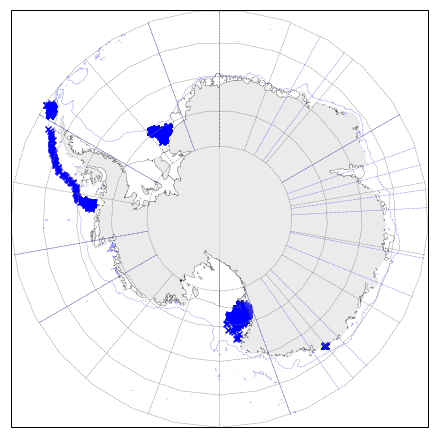

In [27]:
plt.close(1)
plt.figure(1, figsize=(190/25.4, 230/25.4) )

mapax = plt.subplot(projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

DATADIR = "/media/data"

shpfile = DATADIR+"/Datasets/Shapefiles/AntarcticGroundingLine/GSHHS_f_L6.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry']) for shp in records]
ISedgefname = DATADIR+"/Datasets/Shapefiles/AntIceShelf/ne_10m_antarctic_ice_shelves_polys.shp"
ISe_feature = ShapelyFeature(Reader(ISedgefname).geometries(), 
                             ccrs.PlateCarree(), linewidth=0.2,
                             facecolor='none', 
                             edgecolor="k")

mapax.add_geometries(geometries, ccrs.PlateCarree(), edgecolor='0.25', facecolor='0.7',alpha=0.25, linewidth=0.2)
mapax.add_feature(ISe_feature, zorder=3)


gl = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, zorder=2,
              linewidth=0.5, color='gray', alpha=1, linestyle='--')

gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

sel_inds = dfmg.loc[sel_tags].groupby("PROFILE_NUMBER").head(1).index
lons = dfmg.loc[sel_inds, "LONGITUDE"]
lats = dfmg.loc[sel_inds, "LATITUDE"]

region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]
gl_regions = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, linestyle=':', zorder=3)
#gl_regions_lowZ = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, linestyle='--', zorder=1)
gl_regions.xlocator = mticker.FixedLocator(region_lons)
gl_regions.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5) )
gl_regions.xformatter = LONGITUDE_FORMATTER
gl_regions.yformatter = LATITUDE_FORMATTER
gl_regions.ylines = False


bathyS = xr.open_dataset('/media/hdd2/SOSE_1_12/bathyS.nc')
cs = mapax.contour(bathyS.lon, bathyS.lat, bathyS.elevation.where(bathyS.elevation <= 0).values,  levels=[-1000], colors="b", linestyle=":", linewidths=0.25, transform = ccrs.PlateCarree())
    
mapax.scatter(lons, lats, marker="x", color="b", transform = ccrs.PlateCarree() )


In [83]:
import plot_topView_contourf as topView

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


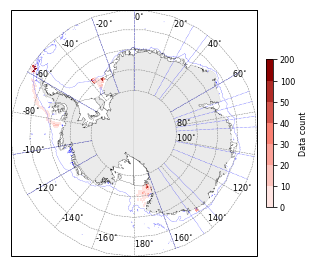

In [33]:
wd=190*0.65/25.4 
ht= 230*0.5 / 25.4
plt.figure(1, figsize=(wd,ht));
gs = gridspec.GridSpec(5, 2, height_ratios=[1]*5, width_ratios=[1, 0.025], wspace=0, hspace=0)

region_lons = [-120, -100, -60, -20, 0, 29, 37, 60, 70, 75, 82, 87, 101, 112, 135, 145, 160, 180]

mapax = plt.subplot(gs[:, 0], projection = ccrs.Orthographic(central_longitude=0, central_latitude=-90) )

levels = list(np.arange(0,51, 10) ) + [100, 200]
#regions = Weddell + PrincessMartha + Harald + CDP + WPB + EPB + LAC + Knox + Adelie + Ross + Amundsen + BS
dfsel = sel_tags
CF1 = topView.plotDataDensity_NIS_DIS(dfmg[dfsel], dfmg, wd=5.8, ht = 5, levels=levels, save=False, dx=0.5, dy=0.5,
                               savename = "./Images/dataDensity/dataDensity_anomalousSalinityTags.jpg", 
                                      mapax=mapax, subplotlabel=None,
                                     region_lons= region_lons)

colorbarax = plt.subplot(gs[1:4, 1])
cbar = Colorbar(ax = colorbarax, mappable = CF1, ticks=levels, orientation='vertical')
cbar.ax.set_ylabel("Data count")

plt.savefig("./Images/dataDensity/dataDensity_anomalousSalinityTags.jpg", dpi=600, bbox_inches="tight")
plt.show()

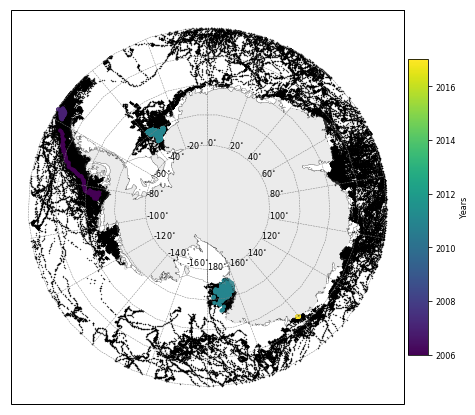

In [74]:
plt.close(1)
plt.figure(1, figsize=(190/25.4, 230/25.4) )
gs = gridspec.GridSpec(5, 3, width_ratios=[1, 0.01, 0.05], wspace=0.0, hspace=0)
mapax = plt.subplot(gs[:,0], projection = ccrs.Orthographic(central_latitude=-90, central_longitude=0) )
cbar_ax = plt.subplot(gs[1:-1,2])


sel_inds = dfmg.loc[~sel_tags].groupby("PROFILE_NUMBER").head(1).index
lons = dfmg.loc[sel_inds, "LONGITUDE"]
lats = dfmg.loc[sel_inds, "LATITUDE"]
years = dfmg.loc[sel_inds, "JULD"].dt.year
mapax.scatter(lons, lats, c="k", s=0.5, marker=".", transform=ccrs.PlateCarree() )

sel_inds = dfmg.loc[sel_tags].groupby("PROFILE_NUMBER").head(1).index
lons = dfmg.loc[sel_inds, "LONGITUDE"]
lats = dfmg.loc[sel_inds, "LATITUDE"]
years = dfmg.loc[sel_inds, "JULD"].dt.year
SC = mapax.scatter(lons, lats, c=years, marker=".", transform=ccrs.PlateCarree() )
cbar = plt.colorbar(mappable = SC, cax = cbar_ax)




#ax.set_ylabel("Latitude")
#ax.set_xlabel("Longitude")
#ax.set_xlim(-180, 180)
#ax.set_xticks(np.arange(-180, 181, 60))

gl = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, zorder=2,
              linewidth=0.5, color='gray', alpha=1, linestyle='--')

gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
gl.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# if region_lons:
#     gl_regions = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, linestyle=':', zorder=3)
#     #gl_regions_lowZ = mapax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='blue', alpha=1, linestyle='--', zorder=1)
#     gl_regions.xlocator = mticker.FixedLocator(region_lons)
#     gl_regions.ylocator = mticker.FixedLocator(np.arange(-80, -59, 5) )
#     gl_regions.xformatter = LONGITUDE_FORMATTER
#     gl_regions.yformatter = LATITUDE_FORMATTER
#     gl_regions.ylines = False

matplotlib.rcParams.update({'font.size': 8})    

shpfile = DATADIR+"/Datasets/Shapefiles/AntarcticGroundingLine/GSHHS_f_L6.shp"
with fiona.open(shpfile) as records:
    geometries = [sgeom.shape(shp['geometry']) for shp in records]
ISedgefname = DATADIR+"/Datasets/Shapefiles/AntIceShelf/ne_10m_antarctic_ice_shelves_polys.shp"
ISe_feature = ShapelyFeature(Reader(ISedgefname).geometries(), 
                             ccrs.PlateCarree(), linewidth=0.2,
                             facecolor='none', 
                             edgecolor="k")

mapax.add_geometries(geometries, ccrs.PlateCarree(), edgecolor='0.25', facecolor='0.7',alpha=0.25, linewidth=0.2)
mapax.add_feature(ISe_feature, zorder=3)

for l in np.arange(-160, 181, 20):
    if( (l == 80) or (l == 100) ):
        text_lat = -80
    else:
        text_lat  = -80.
    mapax.text(l, text_lat, str(l)+"$^{\circ}$", transform=ccrs.PlateCarree() )


cbar.set_label("Years")

plt.savefig("./Images/dataDensity/anomalousSalinityTagsLocation.jpg", dpi=600, bbox_inches="tight")


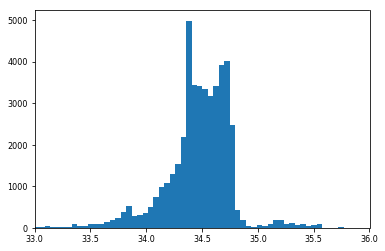

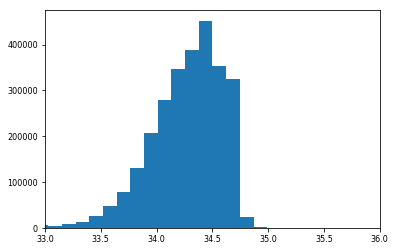

In [82]:
plt.close(1)
plt.figure(1)

salinities_high = dfmg.loc[sel_tags, "PSAL_ADJUSTED"].dropna().values
plt.hist(salinities_high, bins=200)

plt.xlim(33, 36)

plt.figure(2)
salinities_normal = dfmg.loc[~sel_tags, "PSAL_ADJUSTED"].dropna().values
plt.hist(salinities_normal, bins=200)

plt.xlim(33, 36)
plt.show()

The next few cells import necessary custom written functions

In [10]:
import plot_theta_sal
import plot_surfbot_vsTime as pltsurfbot
import plot_topView_contourf as topView

In [11]:
importlib.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_theta_sal.py'>

### Defining regions, water masses, and data selection masks

In [12]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_min'] <= 50
gline_le_100km = dfmg['DIST_min'] <= 100
gline_le_150km = dfmg['DIST_min'] <= 150
gline_le_25km = dfmg['DIST_min'] <= 25
gline_le_75km = dfmg['DIST_min'] <= 75

sel_echodepth = dfmg.ECHODEPTH > -3000

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [13]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [14]:
def play_beep():
    import os
    duration = 1  # second
    freq = np.random.randint(400,800, 10)  # Hz
    for i in range(len(freq)):
        os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq[i]))

In [15]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

### Defining water masses

In [16]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP <= -1.8) & (dfmg.CTEMP >= -1.9)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9) 

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27)

In [14]:
print(len(dfmg[DSW]), len(dfmg[ISW]), len(dfmg[lssw]), len(dfmg.loc[DSW & ISW]), 
      len(dfmg[ISW & lssw]), len(dfmg[lssw & mCDW]), len(dfmg[mCDW]))

102010 126675 182025 0 0 4 164164


In [17]:
DSW_cold = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP <= -1.8)

In [16]:
print(dfmg.loc[Weddell & DSW_cold & gline_le_75km, "CTEMP"].count() 
      / dfmg.loc[Weddell & gline_le_75km , "CTEMP"].count() * 100.)

9.705372616984402


In [14]:
!mkdir ./Images/TSplots2

# Creating array of water mass images

In [18]:
theta_ticks = np.arange(-2.5, 2.1, 0.5)
theta_ticks_major = list(theta_ticks[::2])
theta_ticks_minor = list(theta_ticks[1:][::2])
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]

Function which creates an array of T-S plots

In [22]:
import matplotlib.gridspec as gridspec 
import matplotlib
def plot_waterMassFiguresInGrid(dfmg, regions, thetamin=[-2.5]*4, thetamax=[2]*4, salmin=[31.5]*4, mrows=3, ncols=3,
                           salmax=[35.7]*4, templine=True, s=5, alpha=1, sig_lines=[28, 28.27], wd=10, ht=10, save=False,
                           savename="./Images/TSplots/watermass.png", theta_ticks_major=[theta_ticks_major]*4, 
                           theta_ticks_minor=[theta_ticks_minor]*4,     titles=[],
                           sal_ticks=[sal_ticks]*4, show_legend=False, fontsize=8, colorbar_rowspan=[0,-1]):
    plt.close(1)
    fig = plt.figure(1, figsize=(wd,ht))
    gs = gridspec.GridSpec(mrows, ncols+2, height_ratios=[1]*mrows, width_ratios=[1]*ncols+[0.03,0.05])
    
    matplotlib.rcParams.update({'axes.titlepad':6})
    axarr = []
    counter = 0

    for i in range(mrows):
        for j in range(ncols):
            axarr.append(plt.subplot(gs[i,j]) ) # place it where it should be.
            #axarr.append(plt.subplot2grid((mrows+1, ncols), (i, j)  ))
            
            print(counter)
            SC = plot_theta_sal.plot_theta_s(axarr[-1], dfmg, regions[counter], thetamin=thetamin[i], 
                                             thetamax=thetamax[i], salmin= salmin[i], salmax=salmax[i], 
                                             templine=templine, s=s, alpha=alpha, 
                                        sig_lines=sig_lines, theta_ticks_major= theta_ticks_major[i], 
                                             theta_ticks_minor= theta_ticks_minor[i], sal_ticks=sal_ticks[i], 
                                        show_legend=show_legend, title=titles[counter], fontsize=fontsize)
            if(j > 0):
                axarr[-1].set_yticklabels([])
                axarr[-1].set_ylabel("")
                
            if(i != mrows-1):
                axarr[-1].set_xticklabels([])
                axarr[-1].set_xlabel("")
            if((i == mrows-1) and (j!=1)):
                axarr[-1].set_xlabel("")
                
            
            counter += 1
            if(counter == len(regions)):
                break
        if(counter == len(regions)):
            break
    
    cbax = plt.subplot(gs[colorbar_rowspan[0]:colorbar_rowspan[-1] , ncols+1]) # Place it where it should be.
    # --------------------------------------------------------
    cb = Colorbar(ax = cbax, mappable = SC, orientation = 'vertical', extend='max')
    cb.set_label(r'dbar', labelpad=5)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()

## Watermasses Fig. 1

In [25]:
import imp
imp.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_theta_sal.py'>

0
1
2
3
4
5
6
7
8
9
10
11


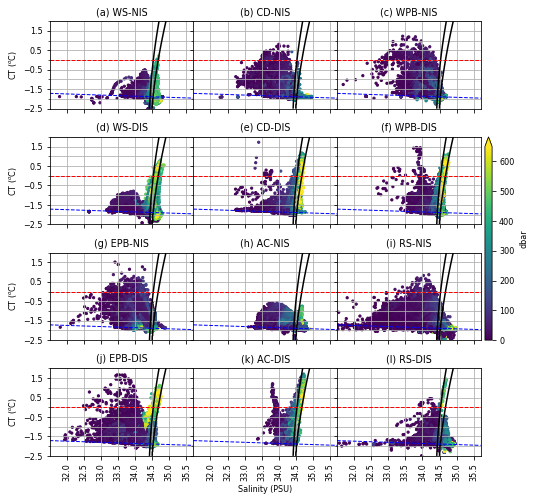

In [26]:
theta_ticks = np.arange(-2.5, 2.1, 0.5)
theta_ticks_major = list(theta_ticks[::2])
theta_ticks_minor = list(theta_ticks[1:][::2])
sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth
regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WS-NIS", "(b) CD-NIS", "(c) WPB-NIS",        
          "(d) WS-DIS", "(e) CD-DIS", "(f) WPB-DIS", 
          "(g) EPB-NIS","(h) AC-NIS", "(i) RS-NIS",
          "(j) EPB-DIS","(k) AC-DIS", "(l) RS-DIS" ] 
          
plot_waterMassFiguresInGrid(dfmg, regions1, titles=titles1, theta_ticks_major=[theta_ticks_major]*4, 
                            theta_ticks_minor=[theta_ticks_minor]*4, sal_ticks=[sal_ticks]*4, 
                            thetamin=[-2.5]*4, thetamax=[2]*4, save=True, 
                            savename="./Images/TSplots2/waterMass1.png", 
                            wd=7.48, ht=7, mrows=4, colorbar_rowspan=[1,3])

0
1
2
3
4
5
6
7
8
9
10
11


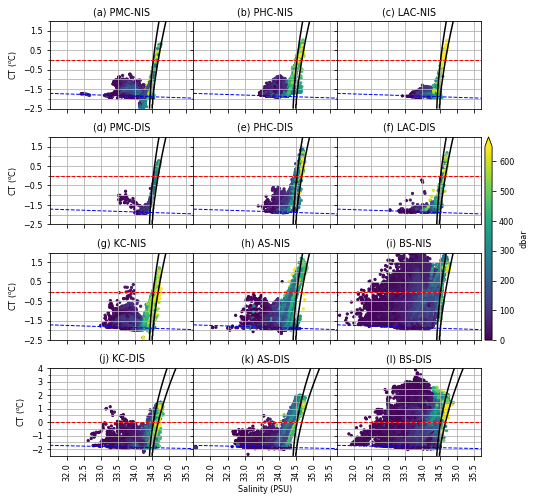

In [151]:
theta_ticks = np.arange(-2.5, 2.1, 0.5)
theta_ticks_major = list(theta_ticks[::2])
theta_ticks_minor = list(theta_ticks[1:][::2])
theta_ticks2 = np.arange(-2., 4.1, 0.5)
theta_ticks_major2 = list(theta_ticks2[::2])
theta_ticks_minor2 = list(theta_ticks2[1:][::2])

sal_ticks = [32, 32.5, 33, 33.5, 34., 34.5, 35, 35.5]
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth
regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMC-NIS", "(b) PHC-NIS", "(c) LAC-NIS", 
           "(d) PMC-DIS", "(e) PHC-DIS", "(f) LAC-DIS",
           "(g) KC-NIS", "(h) AS-NIS", "(i) BS-NIS", 
           "(j) KC-DIS", "(k) AS-DIS", "(l) BS-DIS"]
plot_waterMassFiguresInGrid(dfmg, regions2, titles=titles2, 
                            theta_ticks_major=[theta_ticks_major]*3+[theta_ticks_major2]*1, 
                            theta_ticks_minor=[theta_ticks_minor]*3+[theta_ticks_minor2]*1, 
                            sal_ticks=[sal_ticks]*4, thetamin=[-2.5]*4,
                            thetamax=[2.]*3+[4]*1, save=True, savename="./Images/TSplots2/waterMass2.png", 
                            wd=7.48, ht=7., mrows=4, colorbar_rowspan=[1,3])

In [56]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

In [9]:
dfmg = dfmg.loc[~sel_tags]

In [21]:
dfmg.head()

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,...,DENSITY_INSITU,POT_DENSITY,CTEMP,SA,DIST_GLINE,ECHODEPTH,gamman,SHELF_BREAK_PROFILE,DIST_ISE,DIST_min
0,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',6.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
1,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',8.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
2,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',14.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
3,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',18.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178
4,2007-03-03 03:24:00,-68.5139,78.3736,b'00012048',b'1',22.0,NaN,1,0,NaN,...,NaN,NaN,NaN,NaN,3.943178,-1.0,NaN,False,3.943178,3.943178


# Surface Salinities, Group 1

In [57]:
import matplotlib
def plot_surfbotpropFiguresInGrid(dfmg, regions, titles=[], thetamin=-2.5, thetamax=2, salmin=31.5, mrows=3, ncols=3,
                           salmax=35.7, templine=True, s=5, alpha=1, sig_lines=[27.5, 27.8], wd=10, ht=10, save=False,
                           savename="./Images/surf_bot_prop/surfprop1.png", theta_ticks=[], 
                           sal_ticks=[], show_legend=False, fontsize=8, height_ratios=[],
                           func= pltsurfbot.plot_surface_theta_sal_averages, xlabels=[], rylabels=[], lylabels=[]):
    
    matplotlib.rcParams.update({'axes.titlepad':19, 'font.size':fontsize})
    fig = plt.figure(figsize=(wd,ht))
    axarr = []
    counter = 0
    if not height_ratios:
        height_ratios = [1]*mrows 
    gs = gridspec.GridSpec(mrows, ncols, height_ratios=height_ratios, width_ratios=[1]*ncols)
    
    for i in range(mrows):
        if(height_ratios[i] < 1):
            pass
        else:
            for j in range(ncols):
                axarr.append(plt.subplot(gs[i, j]) )

                #print(counter)
                if(j > 0):
                    count_frame_on = False
                else:
                    count_frame_on=True
                theta_ax, salcount_ax, countax = func(axarr[-1], dfmg, regions[counter], title=titles[counter],
                                                     markersize=3, salmin=salmin,
                                                     salmax=salmax, thetamin=thetamin, thetamax=thetamax, 
                                                     thetaticks=theta_ticks, salticks=sal_ticks, 
                                                      show_legend=show_legend, fontsize=fontsize, 
                                                      count_frame_on=count_frame_on)
                if(j > 0):
                    axarr[-1].set_yticklabels([])
                    axarr[-1].set_ylabel("")
                    countax.set_ylim(1e-1, 5e4)
                    countax.set_axis_off()
                if((j < ncols-1) and (counter < len(regions)-1)):
                    #theta_ax.set_yticklabels([])
                    #theta_ax.set_ylabel("")
                    theta_ax.set_axis_off()
                if(i == 1 or i==4 or i==5):
                    pass
                else:
                    axarr[-1].set_xticklabels([])
                    axarr[-1].set_xlabel("")
                ## uncomment the following just for supplementary bottom figures
                #if(i == mrows-1 and j==0):
                #    theta_ax.set_yticklabels([])
                #    theta_ax.set_ylabel("")

                counter += 1
                if(counter == len(regions)):
                    break
        if(counter == len(regions)):
            break
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0.7)
    
    if(save == True):
        plt.savefig(savename, dpi=300)
    plt.show()


In [58]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

In [13]:
!mkdir ./Images/surf_bot_prop2

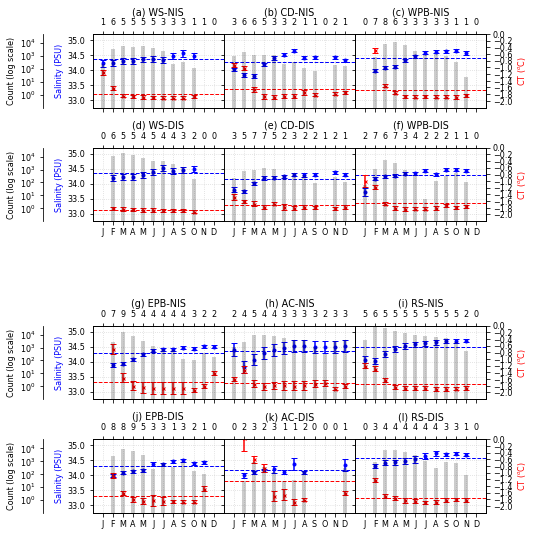

In [59]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 0.1, 0.2))
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth

titles1 = ["(a) WS-NIS", "(b) CD-NIS", "(c) WPB-NIS",        
          "(d) WS-DIS", "(e) CD-DIS", "(f) WPB-DIS", 
          "(g) EPB-NIS","(h) AC-NIS", "(i) RS-NIS",
          "(j) EPB-DIS","(k) AC-DIS", "(l) RS-DIS" ] 
regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]


plot_surfbotpropFiguresInGrid(dfmg, regions1, titles=titles1, func = pltsurfbot.plot_surface_theta_sal_averages,
                              thetamin=-2.2, thetamax=0, salmin=32.75, salmax=35.2, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/surfprop1.pdf")

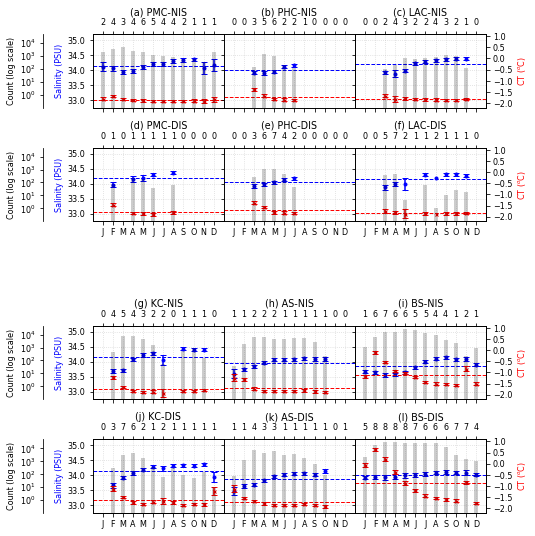

In [60]:
salticks = list(np.arange(33., 35.3, 0.5))
thetaticks = list(np.arange(-2., 1.1, 0.5))
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth

regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]
titles2 = ["(a) PMC-NIS", "(b) PHC-NIS", "(c) LAC-NIS", 
           "(d) PMC-DIS", "(e) PHC-DIS", "(f) LAC-DIS",
           "(g) KC-NIS", "(h) AS-NIS", "(i) BS-NIS", 
           "(j) KC-DIS", "(k) AS-DIS", "(l) BS-DIS"]

plot_surfbotpropFiguresInGrid(dfmg, regions2, titles=titles2, thetamin=-2.2, thetamax=1.1, salmin=32.75, salmax=35.2, 
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              save = True, savename="./Images/surf_bot_prop2/surfprop2.pdf")

# Bottom Salinities array of figures

In [25]:
importlib.reload(pltsurfbot)

<module 'plot_surfbot_vsTime' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_surfbot_vsTime.py'>

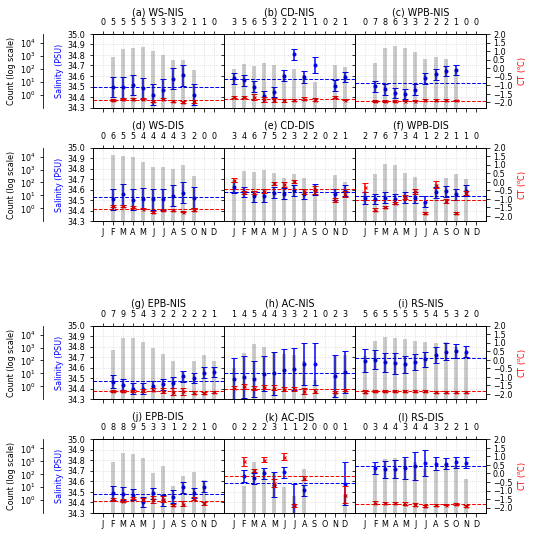

In [61]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250 & sel_echodepth
B2 = ~gline_le_75km & deepMask250 & sel_echodepth

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]


plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_250.pdf")

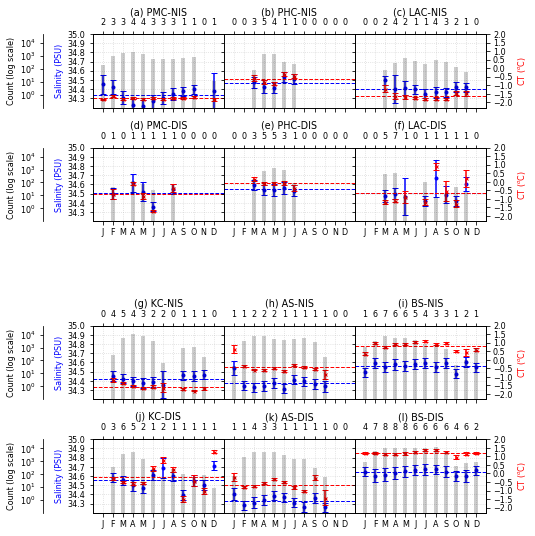

In [62]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask250 & sel_echodepth
B2 = ~gline_le_75km & deepMask250 & sel_echodepth


regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_250.pdf")

## Supplementary figures for deeper bottom-boxes with 375m and 500m top layers

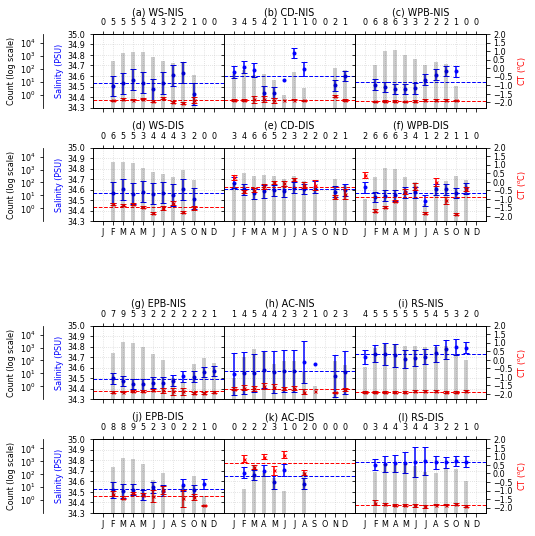

In [63]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375 & sel_echodepth
B2 = ~gline_le_75km & deepMask375 & sel_echodepth

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_375.pdf")

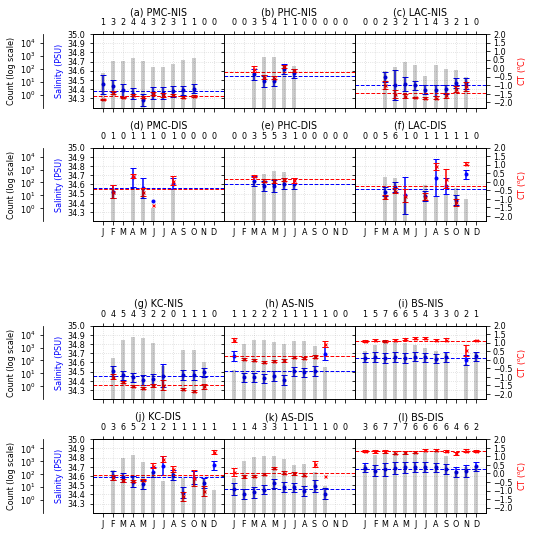

In [64]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask375 & sel_echodepth
B2 = ~gline_le_75km & deepMask375 & sel_echodepth

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_375.pdf")

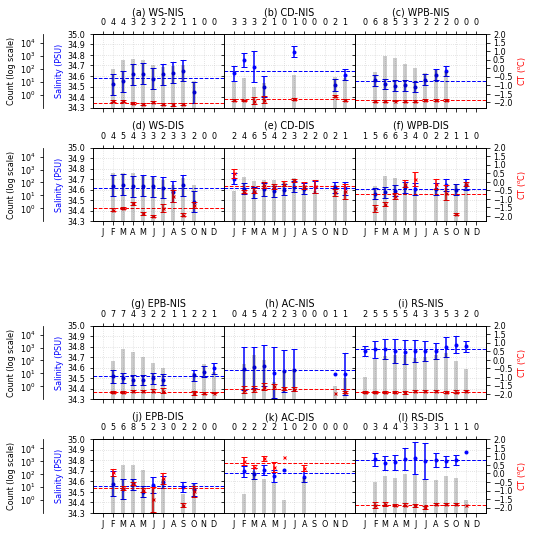

In [65]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500 & sel_echodepth
B2 = ~gline_le_75km & deepMask500 & sel_echodepth

regions1bot = [Weddell & B1, CDP & B1, WPB & B1,   
            Weddell & B2, CDP & B2,    WPB & B2,   
            EPB & B1,     Adelie & B1, Ross & B1, 
            EPB & B2,     Adelie & B2, Ross & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions1bot, titles=titles1, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.3, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop1_500.pdf")

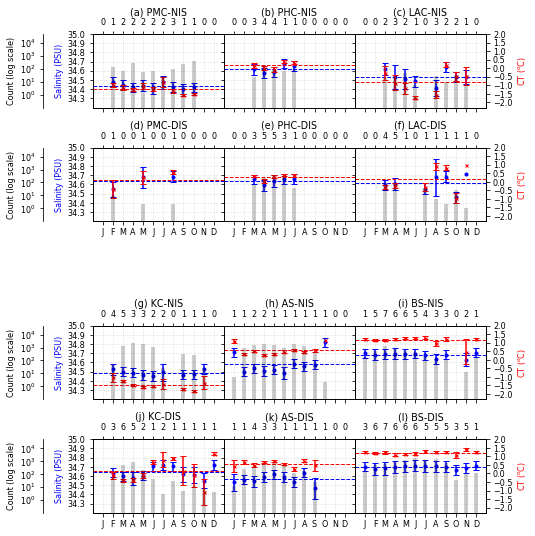

In [66]:
salticks = list(np.arange(34.3, 35.1, 0.1))
thetaticks = list(np.arange(-2., 2.1, 0.5))
B1 = gline_le_75km & deepMask500 & sel_echodepth
B2 = ~gline_le_75km & deepMask500 & sel_echodepth

regions2bot = [PrincessMartha & B1, Harald & B1, (LAC) & B1,
            PrincessMartha & B2, Harald & B2, (LAC) & B2,
            Knox & B1, AS & B1, BS & B1, 
            Knox & B2, AS & B2, BS & B2]

plot_surfbotpropFiguresInGrid(dfmg, regions2bot, titles=titles2, func= pltsurfbot.plot_bottom_theta_sal_averages,
                              thetamin=-2.3, thetamax=2, salmin=34.2, salmax=35., 
                              height_ratios=[1, 1, 0.331, 1, 1, 0.331],
                              theta_ticks=thetaticks, sal_ticks=salticks, mrows=6, ncols=3, wd=7.48, ht=8.16, 
                             save = True, savename="./Images/surf_bot_prop2/botprop2_500.pdf")

### L2 norm between bottom depths 
L2 norm here is calculated as : $$\Large \text{L2 norm of }\Phi_{(375m-250m)} = \sqrt{ \frac{\sum_{i=1}^{i=12} (\Phi_{250_i} - \Phi_{375_i})^2}{12} } $$

Where $i$ ranges over the months. In many regions, less than 12 months of data is available. In such cases, $i$ ranges from 1 to N, where is N is the number of months with non-null data.

In [293]:
def botPropertiesL2Norm(df, region=[]):
    if not region:
        print("Error!! Region cannot be empty!!!")
        return 0
    depthMask250 = df.DEPTH <= -250
    depthMask375 = df.DEPTH <= -375
    depthMask500 = df.DEPTH <= -500
    
    salL2_375 = np.zeros(len(region))
    salL2_500 = np.zeros(len(region))
    thetaL2_375 = np.zeros(len(region))
    thetaL2_500 = np.zeros(len(region))
    salstd250, thetastd250 = np.zeros(len(region)), np.zeros(len(region))
    salstd375, thetastd375 = np.zeros(len(region)), np.zeros(len(region))
    salstd500, thetastd500 = np.zeros(len(region)), np.zeros(len(region))
    
    for i in range(len(region)):
        for area in range(2):
            salmean250 = np.array([np.nan]*12)
            salmean375 = np.array([np.nan]*12)
            salmean500 = np.array([np.nan]*12)
            thetamean250 = np.array([np.nan]*12)
            thetamean375 = np.array([np.nan]*12)
            thetamean500 = np.array([np.nan]*12)
        
        for month in range(12):
            monthMask = df.JULD.dt.month == month+1
                            
            salmean250[month] = df.loc[region[i] & monthMask & depthMask250, "PSAL_ADJUSTED"].mean()
            salmean375[month] = df.loc[region[i] & monthMask & depthMask375, "PSAL_ADJUSTED"].mean()
            salmean500[month] = df.loc[region[i] & monthMask & depthMask500, "PSAL_ADJUSTED"].mean()
                        
            thetamean250[month] = df.loc[region[i] & monthMask & depthMask250, "CTEMP"].mean()
            thetamean375[month] = df.loc[region[i] & monthMask & depthMask375, "CTEMP"].mean()
            thetamean500[month] = df.loc[region[i] & monthMask & depthMask500, "CTEMP"].mean()
            
        salstd250[i] = df.loc[region[i] & depthMask250, "PSAL_ADJUSTED"].std()    
        salstd375[i] = df.loc[region[i] & depthMask375, "PSAL_ADJUSTED"].std()
        salstd500[i] = df.loc[region[i] & depthMask500, "PSAL_ADJUSTED"].std()
        thetastd250[i] = df.loc[region[i] & depthMask250, "CTEMP"].std()
        thetastd375[i] = df.loc[region[i] & depthMask375, "CTEMP"].std()
        thetastd500[i] = df.loc[region[i] & depthMask500, "CTEMP"].std()
        
        salL2_375[i] = np.sqrt(np.nanmean((salmean250 - salmean375)**2)) #/ salstd250
        #salL2_375[i] = (np.sqrt(np.nansum((salmean250 - salmean375)**2))) #WRONG!!!!!!
        
        salL2_500[i] = np.sqrt(np.nanmean((salmean250 - salmean500)**2 )) #/ salstd250
        #salL2_500[i] = (np.sqrt(np.nansum((salmean250 - salmean500)**2 ))) #WRONG!!!!!!
        
        thetaL2_375[i] = np.sqrt(np.nanmean((thetamean250 - thetamean375)**2 )) #/ thetastd250
        #thetaL2_375[i] = (np.sqrt(np.nansum((thetamean250 - thetamean375)**2 ))) #WRONG!!!!!!!!
        
        thetaL2_500[i] = np.sqrt(np.nanmean((thetamean250 - thetamean500)**2 )) #/ thetastd250
        #thetaL2_500[i] = (np.sqrt(np.nansum((thetamean250 - thetamean500)**2 ))) #WRONG!!!!!!!
    
    return salL2_375, salL2_500, thetaL2_375, thetaL2_500, [salstd250, salstd375, salstd500, thetastd250, \
            thetastd375, thetastd500]

In [296]:
A1 = gline_le_75km & sel_echodepth
A2 = ~gline_le_75km & sel_echodepth

regions1 = [Weddell & A1, CDP & A1,    WPB & A1,   
            Weddell & A2, CDP & A2,    WPB & A2,   
            EPB & A1,     Adelie & A1, Ross & A1, 
            EPB & A2,     Adelie & A2, Ross & A2]

titles1 = ["(a) WSA1", "(b) CDA1", "(c) WPBA1",        
          "(d) WSA2", "(e) CDA2", "(f) WPBA2", 
          "(g) EPBA1","(h) ACA1", "(i) RSA1",
          "(j) EPBA2","(k) ACA2", "(l) RSA2" ] 


regions2 = [PrincessMartha & A1, Harald & A1, (LAC ) & A1,
            PrincessMartha & A2, Harald & A2, (LAC ) & A2,
            Knox & A1,  AS & A1, BS & A1, 
            Knox & A2, AS & A2, BS & A2]

titles2 = ["(a) PMCA1", "(b) PHCA1", "(c) LACA1", 
           "(d) PMCA2", "(e) PHCA2", "(f) LACA2",
           "(g) KCA1", "(h) ASA1", "(i) BSA1", 
           "(j) KCA2", "(k) ASA2", "(l) BSA2"]

salL2_375, salL2_500, thetaL2_375, thetaL2_500, stds = botPropertiesL2Norm(dfmg, region=regions1+regions2)

In [295]:
regions_list = titles1 + titles2

for i in range(len(regions_list)):
    print(regions_list[i], '{:0.2f}'.format(stds[0][i]), 
                                    '{:0.2f}'.format(salL2_375[i])+'({:0.2f}'.format(stds[1][i])+")", 
                                    '{:0.2f}'.format(salL2_500[i])+"({:0.2f}".format(stds[2][i])+")",  
                                    '{:0.2f}'.format(stds[3][i]),
                                    '{:0.2f}'.format(thetaL2_375[i])+"({:0.2f}".format(stds[4][i])+")",  
                                    '{:0.2f}'.format(thetaL2_500[i])+"({:0.2f}".format(stds[5][i])+")")

(a) WSA1 0.09 0.04(0.09) 0.10(0.07) 0.31 0.04(0.37) 0.23(0.20)
(b) CDA1 0.14 0.07(0.14) 0.11(0.14) 0.17 0.09(0.13) 0.13(0.11)
(c) WPBA1 0.08 0.02(0.06) 0.05(0.05) 0.07 0.02(0.06) 0.01(0.05)
(d) WSA2 0.11 0.05(0.09) 0.10(0.09) 0.64 0.24(0.70) 0.48(0.78)
(e) CDA2 0.09 0.03(0.08) 0.05(0.07) 0.98 0.18(0.93) 0.24(0.84)
(f) WPBA2 0.07 0.04(0.07) 0.08(0.07) 0.94 0.28(1.04) 0.58(1.15)
(g) EPBA1 0.09 0.03(0.07) 0.06(0.06) 0.11 0.02(0.08) 0.04(0.06)
(h) ACA1 0.08 0.03(0.06) 0.06(0.04) 0.20 0.05(0.22) 0.09(0.16)
(i) RSA1 0.10 0.05(0.09) 0.10(0.10) 0.16 0.03(0.20) 0.04(0.32)
(j) EPBA2 0.11 0.08(0.11) 0.10(0.12) 0.82 0.62(1.00) 0.90(1.01)
(k) ACA2 0.09 0.03(0.07) 0.05(0.05) 0.96 0.16(0.75) 0.21(0.64)
(l) RSA2 0.11 0.04(0.11) 0.06(0.12) 0.50 0.04(0.55) 0.14(0.64)
(a) PMCA1 0.14 0.06(0.09) 0.13(0.08) 0.33 0.16(0.44) 0.59(0.53)
(b) PHCA1 0.15 0.07(0.13) 0.15(0.09) 0.82 0.39(0.75) 0.77(0.49)
(c) LACA1 0.07 0.04(0.07) 0.14(0.10) 0.37 0.19(0.52) 0.99(0.94)
(d) PMCA2 0.10 0.04(0.07) 0.06(0.05) 0.77 0.22(0

In [299]:
regions_list = titles1 + titles2

for i in range(len(regions_list)):
    print(regions_list[i], "&", '{:0.2f}'.format(stds[0][i]), "&",
                                    '{:0.2f}'.format(salL2_375[i]),"&",#+'({:0.2f}'.format(stds[1][i])+")", 
                                    '{:0.2f}'.format(salL2_500[i]),"&",#+"({:0.2f}".format(stds[2][i])+")",  
                                    '{:0.2f}'.format(stds[3][i]),"&",
                                    '{:0.2f}'.format(thetaL2_375[i]),"&",#+"({:0.2f}".format(stds[4][i])+")",  
                                    '{:0.2f}'.format(thetaL2_500[i]))#+"({:0.2f}".format(stds[5][i])+")")

(a) WSA1 & 0.09 & 0.04 & 0.10 & 0.27 & 0.04 & 0.22
(b) CDA1 & 0.14 & 0.07 & 0.11 & 0.17 & 0.09 & 0.13
(c) WPBA1 & 0.08 & 0.02 & 0.05 & 0.07 & 0.02 & 0.01
(d) WSA2 & 0.10 & 0.05 & 0.10 & 0.49 & 0.15 & 0.34
(e) CDA2 & 0.08 & 0.03 & 0.05 & 0.86 & 0.19 & 0.25
(f) WPBA2 & 0.07 & 0.04 & 0.06 & 0.85 & 0.27 & 0.45
(g) EPBA1 & 0.09 & 0.03 & 0.06 & 0.11 & 0.02 & 0.04
(h) ACA1 & 0.08 & 0.03 & 0.06 & 0.20 & 0.05 & 0.09
(i) RSA1 & 0.10 & 0.05 & 0.10 & 0.16 & 0.03 & 0.04
(j) EPBA2 & 0.10 & 0.05 & 0.09 & 0.58 & 0.28 & 0.84
(k) ACA2 & 0.10 & 0.04 & 0.07 & 0.90 & 0.36 & 0.46
(l) RSA2 & 0.11 & 0.04 & 0.06 & 0.26 & 0.04 & 0.06
(a) PMCA1 & 0.14 & 0.06 & 0.13 & 0.32 & 0.16 & 0.60
(b) PHCA1 & 0.15 & 0.07 & 0.15 & 0.81 & 0.39 & 0.77
(c) LACA1 & 0.07 & 0.04 & 0.14 & 0.37 & 0.19 & 0.99
(d) PMCA2 & 0.11 & 0.05 & 0.12 & 0.84 & 0.33 & 0.84
(e) PHCA2 & 0.15 & 0.05 & 0.09 & 0.87 & 0.26 & 0.45
(f) LACA2 & 0.11 & 0.06 & 0.12 & 0.81 & 0.47 & 0.85
(g) KCA1 & 0.10 & 0.05 & 0.08 & 0.40 & 0.10 & 0.15
(h) ASA1 & 0.22 & 0.1

## CDW locations around Antarctica

Location of profiles detecting CDW

In [37]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [38]:
CDW = (dfmg.PSAL_ADJUSTED > 34.5) & (dfmg.CTEMP > 0)

In [39]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

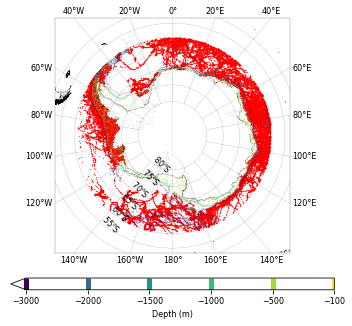

In [78]:
CDWpositions = dfmg.loc[CDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/CDWpositions.png")

In [101]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Weddell",
                              save=True, savename="./Images/dataDensity/WS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5659861x5523520 pixels is too large. It must be less than 2^16 in each direction.

In [102]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Ross",
                              save=True, savename="./Images/dataDensity/RS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8719894x9170325 pixels is too large. It must be less than 2^16 in each direction.

In [42]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Knox", plotBathy=True,
                              save=True, savename="./Images/dataDensity/KC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9722182x5929885 pixels is too large. It must be less than 2^16 in each direction.

In [99]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Adelie",
                              save=True, savename="./Images/dataDensity/AC_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 9969746x7005558 pixels is too large. It must be less than 2^16 in each direction.

In [52]:
importlib.reload(topView)

<module 'plot_topView_contourf' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_topView_contourf.py'>

In [53]:
topView.plot_station_locations(CDWpositions, title='', wd=3, ht=2.6, region="Prydz",
                              save=True, savename="./Images/dataDensity/CD_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 8467006x5464788 pixels is too large. It must be less than 2^16 in each direction.

In [103]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Amundsen",
                              save=True, savename="./Images/dataDensity/AS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5817855x9535680 pixels is too large. It must be less than 2^16 in each direction.

In [104]:
topView.plot_station_locations(CDWpositions, title='', wd=5.8, ht=5, region="Belingshausen",
                              save=True, savename="./Images/dataDensity/BS_CDWpositions.png")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__

ValueError: Image size of 5368344x7915358 pixels is too large. It must be less than 2^16 in each direction.

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3505: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3572: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


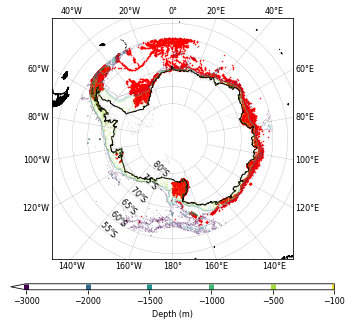

In [38]:
mCDWpositions = dfmg.loc[mCDW, "LATITUDE": "LONGITUDE"].\
                        drop_duplicates(subset=['LONGITUDE', 'LATITUDE']).values
topView.plot_station_locations(mCDWpositions, title='', wd=5.8, ht=5, 
                              save=True, savename="./Images/dataDensity/mCDWpositions.png")

In [19]:
def return_CT_mean_formalError(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = float(df.loc[mask, var].count())
    print("count", CTcount, "sd", CTsd)
    error1 = CTerrorMean 
    error2 = (1.96 * CTsd / np.sqrt(CTcount))
    error3 = np.sqrt(error1**2 + error2**2)
    
    return round(CTmean,2) , error1, CTsd, error2, error3

In [20]:
return_CT_mean_formalError(dfmg, Prydz & gline_le_75km & deepMask250 & sel_months(dfmg, [9]), var="PSAL_ADJUSTED" )

count 618.0 sd 0.02809379413141564


(34.64,
 0.05000000074505806,
 0.02809379413141564,
 0.002214992343975473,
 0.05004903860804597)

In [21]:
def return_CT_mean(df, mask, var='CTEMP'):
    CTmean = df.loc[mask, var].mean()
    CTsd = df.loc[mask, var].std()
    if(var == 'CTEMP'):
        varError = 'TEMP_ADJUSTED_ERROR'
    else:
        varError = var+'_ERROR'
        
    CTerrorMean = df.loc[mask, varError].mean()
    CTcount = df.loc[mask, var].count()
    
    error = np.sqrt(CTerrorMean**2 + (1.96 * CTsd / np.sqrt(CTcount))**2)
    
    return round(CTmean,2) , round(error,2)

### March to May, Weddell Sea - difference between Filchner Ice Shelf and Stancomb Brunt Ice Shelf

In [27]:
FIS = (dfmg.LONGITUDE > -45) & (dfmg.LONGITUDE < -30) & gline_le_75km & sel_echodepth
StancombBrunt = (dfmg.LONGITUDE > -30) & (dfmg.LONGITUDE < -20) & gline_le_75km & sel_echodepth

return_CT_mean(dfmg, (StancombBrunt &  deepMask250) )

(-1.73, 0.05)

In [27]:
return_CT_mean(dfmg, (ISW & Ross & ~gline_le_75km &  deepMask250) , var="PSAL_ADJUSTED")

(34.78, 0.12)

In [27]:
return_CT_mean(dfmg, Weddell & gline_le_75km & deepMask500 & sel_months(dfmg, [7,8,9]), var="CTEMP")

(-2.11, 0.05)

In [301]:
return_CT_mean(dfmg, LAC & gline_le_75km & deepMask250)

(-1.7, 0.1)

In [251]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask500)# & sel_months(dfmg, [3,4,5]))

(-1.47, 0.05)

In [72]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250)

(-1.75, 0.046551529449024444)

In [73]:
return_CT_mean(dfmg, PrincessMartha & gline_le_75km & deepMask250, var="PSAL_ADJUSTED")

(34.3, 0.063763968423933781)

In [13]:
return_CT_mean(dfmg, LAC & gline_le_75km & deepMask500)

(-0.88, 0.20277397804359704)

In [14]:
return_CT_mean(dfmg, Knox & gline_le_75km & deepMask500)

(-1.49, 0.05407613216137537)

In [15]:
return_CT_mean(dfmg, CDP & gline_le_75km & deepMask500)

(-1.81, 0.14933881212951569)

In [60]:
highSal = dfmg["PSAL_ADJUSTED"] > 35

In [64]:
dfmg.loc[highSal, "PLATFORM_NUMBER"].unique()

array(["b'00057726'", "b'00021078'", "b'00009654'", "b'00012426'",
       "b'00022014'", "b'00022062'", "b'00022056'", "b'00027498'"],
      dtype=object)

In [65]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman', 'SHELF_BREAK_PROFILE',
       'DIST_ISE', 'DIST_min'],
      dtype='object')

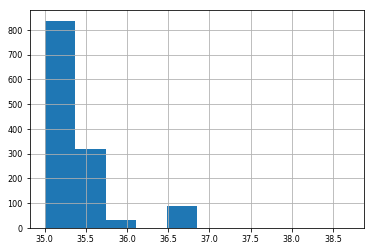

In [71]:
dfmg.loc[highSal, "PSAL_ADJUSTED"].hist()

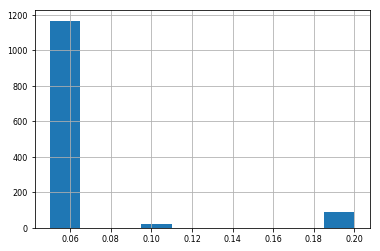

In [69]:
dfmg.loc[highSal, "PSAL_ADJUSTED_ERROR"].hist()

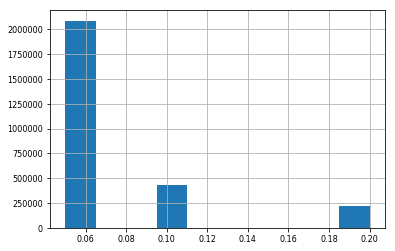

In [70]:
dfmg.loc[:, "PSAL_ADJUSTED_ERROR"].hist()

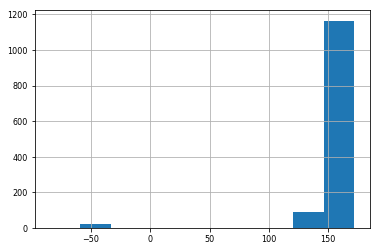

In [92]:
dfmg.loc[highSal, "LONGITUDE"].hist()

In [102]:
print(dfmg[highSal & Ross].PSAL_ADJUSTED.count(),
dfmg[ Ross].PSAL_ADJUSTED.count())

1165 302834


In [125]:
DSW_cool = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8) #& (dfmg.CTEMP >= -1.9)

In [253]:
regions = [Weddell, PrincessMartha, Harald, CDP, WPB, EPB, LAC, Knox, Adelie, Ross, AS, BS]
names = ["WS", "PMC", "PHC", "CDP", "WPB", "EPB", "LAC", "KC", "AC", "RS", "AS", "BS"]
dfsel = sel_months(dfmg, [6,7,8,9,10,11]) & gline_le_75km & ~dfmg.CTEMP.isna()

for i in range(len(regions)):
    print(names[i], dfmg.loc[dfsel & regions[i], "CTEMP"].count(), 
          dfmg.loc[dfsel & regions[i] & DSW_cool, "CTEMP"].count() / 
                         dfmg.loc[dfsel & regions[i], "CTEMP"].count() * 100)

WS 14987 10.002001734836858
PMC 10778 0.0
PHC 928 0.0
CDP 2237 57.66651765757711
WPB 13919 74.83296213808464
EPB 7523 16.841685497806726
LAC 8508 0.011753643629525152
KC 10322 1.1335012594458438
AC 23351 34.61093743308638
RS 66339 76.68942854128039
AS 37025 0.008102633355840648
BS 77787 0.0


In [168]:
def compute_errors(df, var="PSAL", long_bins=np.arange(-180, 180.1, 2), ylims=[1e-3, 1e0]):
    var_error_long_bins = df[var+"_ADJUSTED_ERROR"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).mean()
    var_std_long_bins = df[var+"_ADJUSTED"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).std()
    var_count_long_bins = df[var+"_ADJUSTED"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).count()
    var_stat_error_long_bins = 1.96 * var_std_long_bins / np.sqrt(var_count_long_bins)
    
    total_error = np.sqrt(var_error_long_bins**2 + var_stat_error_long_bins**2)
    
    plt.plot(long_bins[1:], var_error_long_bins, "bo", label="instr.")
    plt.scatter(long_bins[1:], var_stat_error_long_bins.values, color="0.5", label="stat.")#, "go", label="stat.")
    plt.plot(long_bins[1:], var_std_long_bins, "ro", label="std.")
    plt.scatter(long_bins[1:], total_error.values, color="0.25", marker="x", label="total")
    plt.yscale("log")
    #plt.yticks([1e-2, 1e-1, 1e0])
    plt.ylim(ylims[0], ylims[1])
    plt.legend()
    plt.grid()
    plt.show()
    

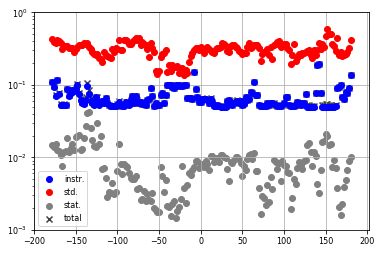

In [169]:
compute_errors(dfmg)

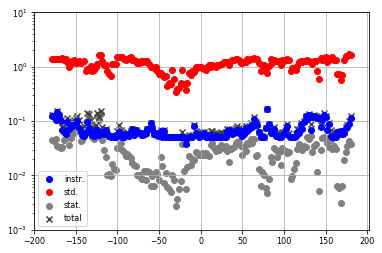

In [170]:
compute_errors(dfmg, var="TEMP", ylims=[1e-3, 1e1])

In [221]:
regions = [Weddell, PrincessMartha, Harald, CDP, WPB, EPB, LAC, Knox, Adelie, Ross, AS, BS]
names = ["WS", "PMC", "PHC", "CDP", "WPB", "EPB", "LAC", "KC", "AC", "RS", "AS", "BS"]
bottom_temperatures = np.zeros(12)
bottom_temperatures_error = np.zeros(12)
for i in range(len(regions)):
    dfsel = regions[i] & gline_le_50km & deepMask250 & sel_months(dfmg, [7,8,9])
    bottom_temperatures[i] = dfmg.loc[dfsel, "CTEMP"].mean()
    instr_error = dfmg.loc[dfsel, "TEMP_ADJUSTED_ERROR"].mean()
    
    std = dfmg.loc[dfsel, "CTEMP"].std()
    count = dfmg.loc[dfsel , "CTEMP"].count()
    
    bottom_temperatures_error[i] = np.sqrt(instr_error**2 + (1.96 * std / np.sqrt(count) )**2 )
    
sorted_inds = np.argsort(bottom_temperatures)
for j in range(12):
    print(names[sorted_inds[j]], bottom_temperatures[sorted_inds[j]], bottom_temperatures_error[sorted_inds[j]])

WS -1.878112337249835 0.05181030192045885
RS -1.867939498797423 0.057212018343559885
WPB -1.864614366750626 0.050015803369186596
CDP -1.842750060525542 0.050163900101713545
EPB -1.8363923110836784 0.18192979781062463
LAC -1.8004473995018835 0.07269599996409247
KC -1.7915704343902328 0.0842220877740645
AC -1.7785308030415035 0.13078789287003123
PMC -1.7585926951502782 0.05241670783028134
AS -0.47798790799947605 0.05487153661576121
BS 0.6081014246008847 0.05763821112056428
PHC nan nan


In [189]:
def compute_means(df, var="PSAL", long_bins=np.arange(-180, 180.1, 2), ylims=[1e-3, 1e0]):
    var_error_long_bins = df[var+"_ADJUSTED_ERROR"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).mean()
    var_std_long_bins = df[var+"_ADJUSTED"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).std()
    var_count_long_bins = df[var+"_ADJUSTED"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).count()
    var_stat_error_long_bins = 1.96 * var_std_long_bins / np.sqrt(var_count_long_bins)
    
    total_error = np.sqrt(var_error_long_bins**2 + var_stat_error_long_bins**2)
    
    var_mean = df[var+"_ADJUSTED"].groupby(pd.cut(df.LONGITUDE, long_bins ) ).mean()
    
    plt.errorbar(long_bins[1:], var_mean.values, yerr=total_error, marker=".", capsize=3)
    
    plt.grid()
    plt.show()
    

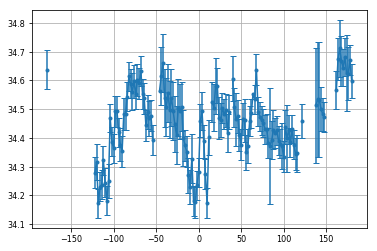

In [192]:
compute_means(dfmg[gline_le_75km & deepMask250])

<IPython.core.display.Javascript object>


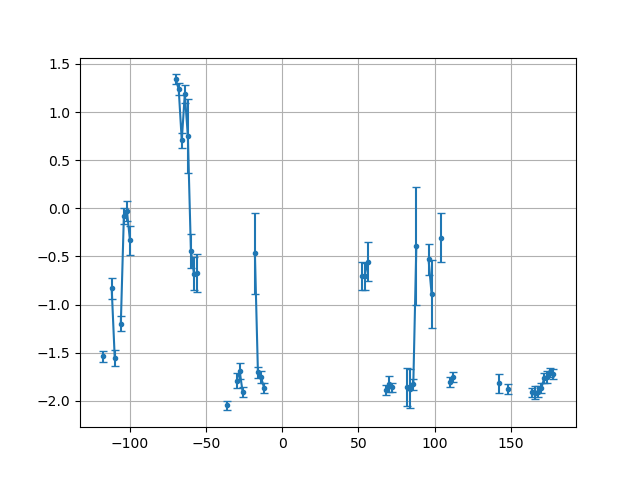

In [201]:
compute_means(dfmg[gline_le_75km & deepMask250 & sel_months(dfmg, [9]) ], var="TEMP")

<IPython.core.display.Javascript object>


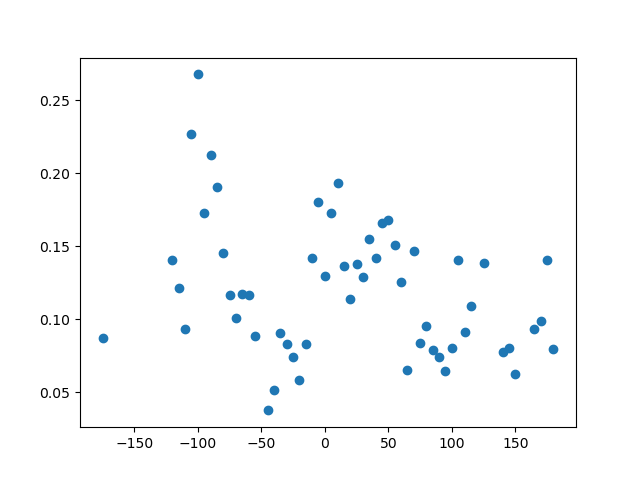

In [231]:
var = "PSAL"
long_bins=np.arange(-180, 180.1, 5)
dfsel = gline_le_75km & deepMask250
sal_longbin = dfmg.loc[dfsel, "PSAL_ADJUSTED"].groupby(pd.cut(dfmg[dfsel].LONGITUDE, long_bins ) ).std()

plt.plot(long_bins[1:], sal_longbin.values, "o")
plt.show()

In [289]:
dfsel = gline_le_75km & ISW & Knox
return_CT_mean(dfmg, dfsel, var="PSAL_ADJUSTED")

(34.79, 0.1)

In [292]:
dfsel = gline_le_75km & ISW & Knox
dfmg.loc[dfsel & DSW_cool, "CTEMP"].count() / dfmg.loc[dfsel, "CTEMP"].count() * 100

2.9676258992805753

In [305]:
dfsel = Ross & (dfmg.PSAL_ADJUSTED > 35)
sel_pfnos = dfmg.PLATFORM_NUMBER.isin(dfmg.loc[dfsel, "PLATFORM_NUMBER"].unique().tolist())

In [312]:
dfmg[dfsel].PSAL_ADJUSTED.count()

1165

In [313]:
dfmg.loc[sel_pfnos, "PSAL_ADJUSTED"].count()

17103

<IPython.core.display.Javascript object>


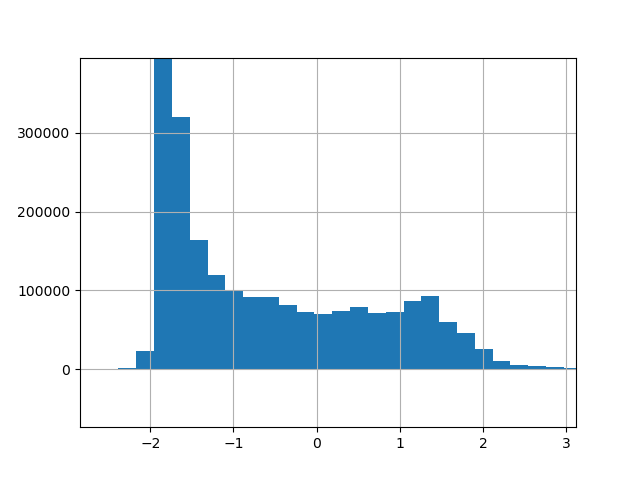

In [324]:
dfmg.CTEMP.hist(bins=100)

In [410]:
import numpy.ma as ma

In [373]:
def count_sal_temp(gdf, temprange, ret='range_count'):
    if ret == 'range_count':
        return gdf.CTEMP.groupby(pd.cut(gdf.CTEMP, temprange) ).count().values
    if ret == 'total_count':
        return gdf.CTEMP.count()

In [606]:
regions_cold = Weddell + CDP + WPB + EPB + Adelie + Ross
regions_warm = Amundsen + BS + Harald
regions_inter = PrincessMartha + LAC + Knox
regions = [regions_cold, regions_inter, regions_warm]
regions_all = regions[0] | regions[1] | regions[2]

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [675]:
import sys
sys.path.insert(0, "/usr/local/MATLAB/R2018a/extern/engines/python/build/lib.linux-x86_64-2.7")
import matlab.engine

def plot_prob_TS(dfsel, ax, salrange=np.arange(33.5, 35.50001, 0.05), temprange=np.arange(-2.4, 2.40001, 0.1), 
                 save=False, savename="untitled.pdf", vmin=0, vmax=0.015):
    
    watermasses = [DSW, ISW, lssw, mCDW, CDW]
    colormaps = ["Blues", "Blues", "Greys", "Oranges", "Reds"]
    prob_integrated = 0.0
    CF = []
    eng = matlab.engine.start_matlab()
    eng.addpath('/media/work/MyPrograms/EOS80/')
    eng.addpath('/media/work/MyPrograms/EOS80/library/')
    
    salgrid, tempgrid = np.linspace(salrange.min(), salrange.max(), 100), np.linspace(temprange.min(), temprange.max(), 100)
    SS, TT = np.meshgrid(salgrid, tempgrid)
    #SS, TT = np.meshgrid(salrange, temprange) 
                         
    SS = matlab.double(SS.tolist())
    TT = matlab.double(TT.tolist())

    gamman_mesh = eng.eos80_legacy_gamma_n(SS, TT, 0.0, 0.0, -70.0);
    ax.contour(salgrid, tempgrid, gamman_mesh, levels=[28, 28.27], colors='k', linewidths=1)
    for w in range(5):
        try:
            df = dfmg[dfsel & watermasses[w]]
            range_counts = df.groupby(pd.cut(df.PSAL_ADJUSTED, salrange)).apply(count_sal_temp, temprange, ret='range_count')
            total_counts = df.groupby(pd.cut(df.PSAL_ADJUSTED, salrange)).apply(count_sal_temp, temprange, ret='total_count')

            total_counts = ma.masked_array(np.array(total_counts), mask = (total_counts < 5))
            range_counts = ma.masked_array(np.array(range_counts), mask = total_counts.mask)
            probability_TS = np.zeros((len(salrange)-1, len(temprange)-1))
            count = dfmg[regions_all & sel_echodepth].CTEMP.count()

            for i in range(len(salrange)-1):
                probability_TS[i] = (range_counts[i]) #/ float(count)
            probability_TS = probability_TS / count
            prob_integrated += probability_TS.sum()
            probability_TS = ma.masked_array(probability_TS, mask = (probability_TS < 1e-6) )
            CF.append(ax.pcolormesh(salrange[:-1], temprange[:-1], probability_TS.T, cmap=colormaps[w], 
                                    vmin=vmin, vmax=vmax))
            
        except:
            pass
    ax.set_xticks(np.arange(33.5, 35.5001, 0.1), minor=True)
    ax.set_xticks(np.arange(33.5, 35.50001, 0.5))
    
    ax.set_yticks(np.arange(-2.4, 2.40001, 0.1), minor=True )
    #ax.set_yticks(np.arange)
    
    ax.set_ylabel("Conservative Temperature $^{\circ}$C")
    ax.set_xlabel("Salinity (PSU)")
    print(prob_integrated)
    return CF
    
    
    

0.3528153089859733


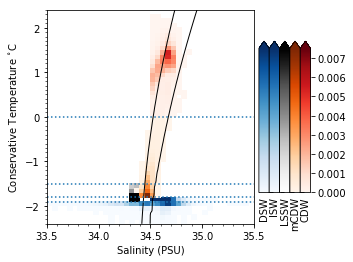

In [676]:
plt.close(1)
plt.figure(1, figsize=(120/25.4, 100/25.4))
gs = gridspec.GridSpec(7, 7, height_ratios=[1]*7, wspace=0, width_ratios=[1, 0.025]+[0.05]*5)
ax = plt.subplot(gs[:, 0])
regions_all = regions[0] | regions[1] | regions[2]

CF = plot_prob_TS(regions_all & sel_echodepth, ax, vmax=0.0075)
ax.axhline(-1.9, linestyle=":")
ax.axhline(-1.8, linestyle=":")
ax.axhline(-1.5, linestyle=":")
ax.axhline(0, linestyle=":")

cbar_titles = ["DSW", "ISW", "LSSW", "mCDW", "CDW"]
for i in range(0,5,1):
    colorbarax = plt.subplot(gs[1:6, i+2])
    Colorbar(mappable=CF[i], ax = colorbarax, extend="max")
    if i < 4:
        colorbarax.set_yticklabels([])
    colorbarax = plt.subplot(gs[-1, i+2])
    colorbarax.text(0,0.75,cbar_titles[i], rotation="90")
    colorbarax.axis("off")

plt.savefig("./Images/TSplots2/prob_TS.pdf", dpi=300, bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


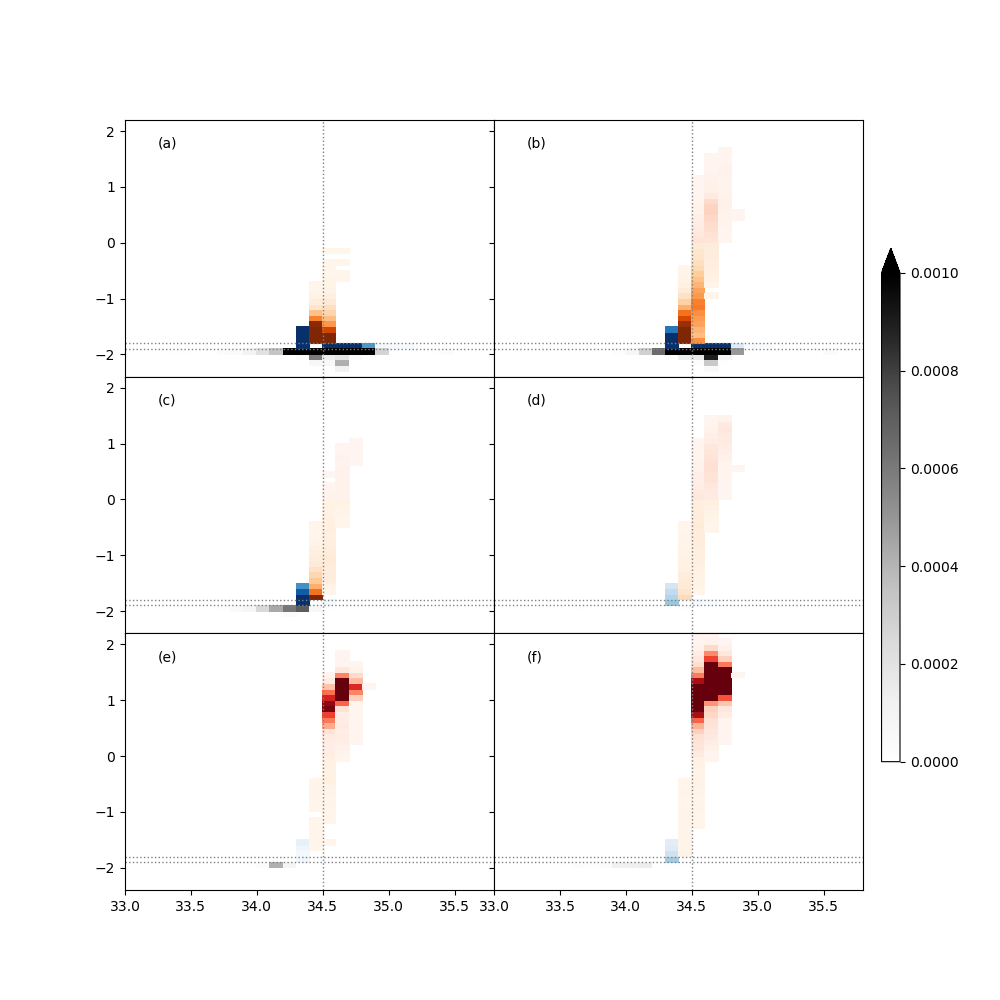

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [543]:
plt.close(1)
fig = plt.figure(1, figsize=(10, 10))
gs = gridspec.GridSpec(6, 4, width_ratios=[1, 1, 0.05, 0.05], wspace=0, hspace=0)

regions_cold = Weddell + CDP + WPB + EPB + Adelie + Ross
regions_warm = Amundsen + BS + Harald
regions_inter = PrincessMartha + LAC + Knox
regions = [regions_cold, regions_inter, regions_warm]

vmax = [0.001, 0.001, 0.001]
rows = [[0,2], [2,4], [4,6]]
label = [["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]]
CF = []
ax = []
for i in range(0,3,1):
    #near-ice-shelf Prob(T,S) plot
    ax.append(plt.subplot(gs[rows[i][0] : rows[i][1], 0]))
    CF.append(plot_prob_TS(gline_le_75km & sel_echodepth & regions[i], ax[-1], vmax=vmax[i]))
    ax[-1].text(33.25, 1.7, label[i][0])
    if i < 2:
        ax[-1].set_xticklabels([])
    #distant-from-ice-shelf Prob(T,S) plot
    ax.append(plt.subplot(gs[rows[i][0] : rows[i][1], 1]))
    CF.append(plot_prob_TS(~gline_le_75km & sel_echodepth & regions[i], ax[-1], vmax=vmax[i]))
    ax[-1].set_yticklabels([])
    ax[-1].text(33.25, 1.7, label[i][1])
    if i < 2:
        ax[-1].set_xticklabels([])
        
    for i in range(1,3,1):
        ax[-i].axhline(-1.9, linewidth=1, linestyle=":", color="gray")
        ax[-i].axhline(-1.8, linewidth=1, linestyle=":", color="gray")
        ax[-i].axvline(34.5, linewidth=1, linestyle=":", color="gray")

colorbarax = plt.subplot(gs[1:5, 3])
Colorbar(ax=colorbarax, mappable=CF[0][1], extend='max')

plt.show()
#plt.savefig(savename, dpi=300, bbox_inches="tight")